In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Параметры
batch_size = 128
learning_rate = 1e-3
num_epochs = 10
latent_dim = 20


In [7]:
# Загрузка данных
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21301203.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 649033.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5538340.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8197301.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
# Определение VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # для среднего
        self.fc22 = nn.Linear(400, latent_dim)  # для логарифма дисперсии
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [13]:
# Функция потерь
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Функция вычисления точности
def calculate_accuracy(recon_x, x):
    recon_x = recon_x.view(-1, 28 * 28)
    x = x.view(-1, 28 * 28)
    correct = torch.sum((recon_x > 0.5) == (x > 0.5)).item()
    return correct / (x.size(0) * 28 * 28)

In [14]:
# Обучение модели
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        accuracy = calculate_accuracy(recon_batch, data)
        train_accuracy += accuracy

        if batch_idx % 100 == 0:
            print(f'Эпоха: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tПотеря: {loss.item() / len(data):.6f}\tТочность: {accuracy:.4f}')

    avg_loss = train_loss / len(dataloader.dataset)
    avg_accuracy = train_accuracy / len(dataloader)
    print(f'====> Эпоха: {epoch} Средняя потеря: {avg_loss:.4f}\tСредняя точность: {avg_accuracy:.4f}')

Эпоха: 0 [0/60000 (0%)]	Потеря: 551.366882	Точность: 0.4898
Эпоха: 0 [12800/60000 (21%)]	Потеря: 183.123764	Точность: 0.8979
Эпоха: 0 [25600/60000 (43%)]	Потеря: 149.899384	Точность: 0.9240
Эпоха: 0 [38400/60000 (64%)]	Потеря: 139.823822	Точность: 0.9348
Эпоха: 0 [51200/60000 (85%)]	Потеря: 135.591248	Точность: 0.9390
====> Эпоха: 0 Средняя потеря: 164.4583	Средняя точность: 0.9161
Эпоха: 1 [0/60000 (0%)]	Потеря: 128.912720	Точность: 0.9452
Эпоха: 1 [12800/60000 (21%)]	Потеря: 125.503273	Точность: 0.9473
Эпоха: 1 [25600/60000 (43%)]	Потеря: 122.871063	Точность: 0.9494
Эпоха: 1 [38400/60000 (64%)]	Потеря: 116.647202	Точность: 0.9543
Эпоха: 1 [51200/60000 (85%)]	Потеря: 119.245712	Точность: 0.9541
====> Эпоха: 1 Средняя потеря: 121.1867	Средняя точность: 0.9507
Эпоха: 2 [0/60000 (0%)]	Потеря: 110.999069	Точность: 0.9591
Эпоха: 2 [12800/60000 (21%)]	Потеря: 118.930328	Точность: 0.9536
Эпоха: 2 [25600/60000 (43%)]	Потеря: 114.500954	Точность: 0.9557
Эпоха: 2 [38400/60000 (64%)]	Потеря: 111

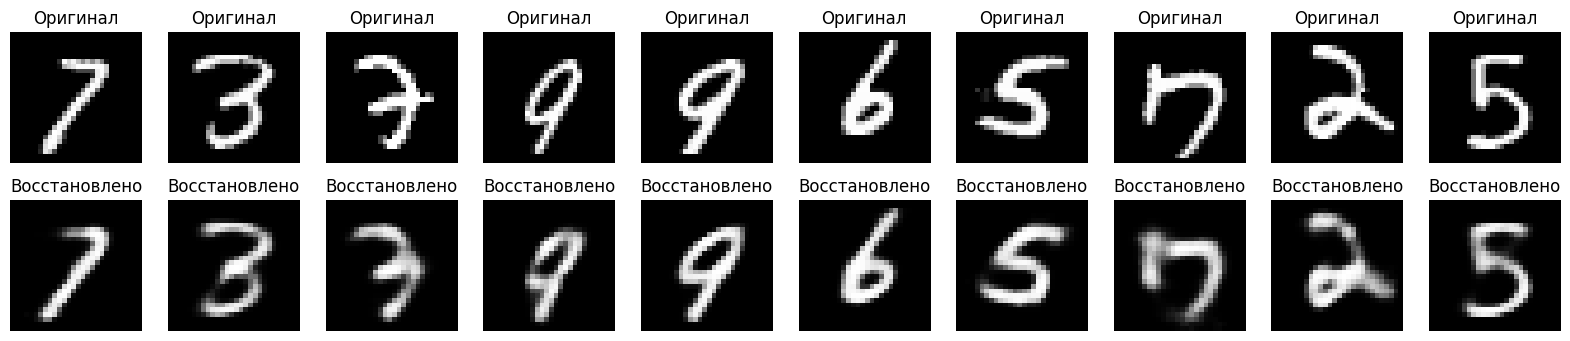

In [17]:
# Вывод исходных и восстановленных изображений
model.eval()
with torch.no_grad():
    # Взять 10 случайных изображений из датасета
    sample_data, _ = next(iter(dataloader))
    sample_data = sample_data[:10]  # взять первые 10 изображений

    # Пропустить через модель для кодирования и декодирования
    recon_batch, _, _ = model(sample_data)

    # Визуализация исходных и восстановленных изображений
    plt.figure(figsize=(20, 4))
    for i in range(10):
        original_image = sample_data[i].view(28, 28).cpu().numpy()
        reconstructed_image = recon_batch[i].view(28, 28).cpu().numpy()

        # Оригинальные изображения
        plt.subplot(2, 10, i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title("Оригинал")
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title("Восстановлено")
        plt.axis('off')

    plt.show()